In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
file = open("data_exp_density_pnt1_3_19_2021_0_24.pkl", 'rb')
stuff = pickle.load(file, encoding='latin1')
file.close()

In [3]:
objfs = stuff["objfs"]
objfs_validation = stuff["objfs_validation"]
lower_bounds = stuff["lower_bounds"]
runtimes = stuff["runtimes"]
opt_res_norms = stuff["opt_res_norms"]

alg_props = stuff["alg_props"]
time_cost_details = stuff["time_cost_details"]
best_xs = stuff["best_xs"]

ts = stuff["ts"]
q_norms = stuff["q_norms"]
f_grad_norms = stuff["f_grad_norms"]
num_f_evas_line_searchs = stuff["num_f_evas_line_searchs"]
baseline_objf_opt_s = stuff["baseline_objf_opt_s"]

In [4]:
eps_gap_rel=1e-4
eps_res_abs=1e-4
eps_res_rel=1e-4

In [5]:
num_trials, num_algs, max_num_rounds = objfs.shape
n, _, _ = best_xs.shape
res_start_idx = 1
alg_idx = 0

In [6]:
stop_iters = [max_num_rounds] * 2
for i in range(10, max_num_rounds):
    if objfs[0, 0, i] < np.inf and \
                    objfs[0, 0, i] - lower_bounds[0, 0, i] <= np.abs(objfs[0, 0, i] - objfs_validation[0, 0, i]) \
                    + eps_gap_rel * np.abs(objfs[0, 0, i]):
        stop_iters[0] = min(i, stop_iters[0])
    if ts[0, 0, i] == 1 and opt_res_norms[0, 0, i] <= n * eps_res_abs \
                    + eps_res_rel * (q_norms[0, 0, i] + f_grad_norms[0, 0, i]):
        stop_iters[1] = min(i, stop_iters[1])
    if max(stop_iters) < max_num_rounds:
        break
print("iteration at which a stopping condition holds", stop_iters)
stop_iter = min(stop_iters)

iteration at which a stopping condition holds [10, 100]


In [7]:
objfs_best = np.array(objfs)
for i in range(1, max_num_rounds):
    objfs_best[0, 0, i] = np.min(objfs[0, 0, 0:i + 1])

opt_res_norms_best = np.array(opt_res_norms)
for i in range(res_start_idx, max_num_rounds):
    opt_res_norms_best[0, alg_idx, i] = np.min(opt_res_norms[0, alg_idx, res_start_idx:i + 1])

In [8]:
linewidth = 2
fontsize = 16
font = {'family': 'serif',
        'size': fontsize,
        }

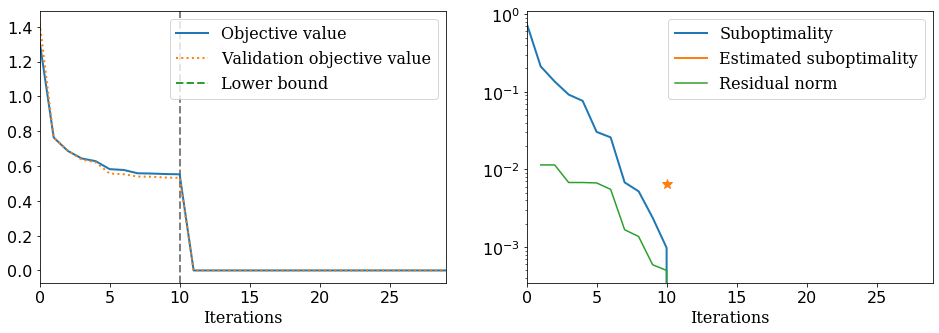

In [9]:
fig = plt.figure(tight_layout=False, figsize=(16, 5))
gs = gridspec.GridSpec(1, 2)
plt.rcParams.update({'font.size': fontsize})

plot1 = fig.add_subplot(gs[0, 0])
rounds = range(0, max_num_rounds)
if stop_iter < max_num_rounds:
    plot1.axvline(stop_iter, color='gray', linestyle='dashed', linewidth=linewidth)
##objf
plot1.plot(np.array(rounds), objfs_best[0, alg_idx, 0:max_num_rounds], linewidth=linewidth, 
           label="Objective value")
##objf_validation
plot1.plot(np.array(rounds), objfs_validation[0, alg_idx, 0:max_num_rounds], ':', linewidth=linewidth, 
           label="Validation objective value")
##l_k
if np.max(lower_bounds[0, alg_idx, 0:max_num_rounds]) > -np.inf:
    plot1.plot(np.array(rounds), lower_bounds[0, alg_idx, 0:max_num_rounds], '--', linewidth=linewidth, 
               label="Lower bound")

plot1.set_xlabel("Iterations", fontdict=font)
plot1.legend(prop=font)

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
##subopt
if baseline_objf_opt_s is None:
    objf_min = np.min(objfs[0, alg_idx, :])
else:
    objf_min = baseline_objf_opt_s[0, alg_idx]
plot2.plot(np.array(rounds), objfs_best[0, alg_idx, 0:max_num_rounds] - objf_min, linewidth=linewidth, 
           label="Suboptimality")
## gaps
gaps = objfs_best[0, alg_idx, 0:max_num_rounds] - lower_bounds[0, alg_idx, 0:max_num_rounds]
if np.min(gaps) < np.inf:
    plot2.plot(rounds, gaps, linewidth=linewidth, label="Estimated suboptimality")
if stop_iters[0] < max_num_rounds:
    plot2.plot(stop_iters[0], gaps[stop_iters[0]], ' *', color='#ff7f0e', markersize=10)
## residual norm
plot2.plot(rounds[res_start_idx::], opt_res_norms_best[0, 0, res_start_idx::] / n, 
           label="Residual norm", color='#2ca02c')
if stop_iters[1] < max_num_rounds:
    plot2.plot(stop_iters[1], opt_res_norms_best[0, 0, stop_iters[1]] / n, ' *', color='#2ca02c', markersize=10)

plot2.set_xlabel("Iterations", fontdict=font)
plot2.set_yscale("log")
plot2.legend(prop=font)

plot_iter_lim = 29
ylim = None
if plot_iter_lim is not None:
    plot1.set_xlim([0, plot_iter_lim])
    plot2.set_xlim([0, plot_iter_lim])
if ylim is not None:
    plot2.set_ylim([ylim[0], ylim[1]])

# fig.savefig("vecnewsven_pnt1_cvg.pdf")

In [10]:
solve_time = np.sum(runtimes[0, alg_idx, 0:np.min(stop_iters) + 1])
f_evals = np.mean(num_f_evas_line_searchs[0, alg_idx, 1:np.min(stop_iters) + 1], axis=0)
print("alg_idx =", alg_idx, ", solve time = ", '{:g}'.format(float('{:.2g}'.format(solve_time))),
    ", iterations=", np.min(stop_iters), ", f evals=", '{:g}'.format(float('{:.2g}'.format(f_evals))))

alg_idx = 0 , solve time =  0.35 , iterations= 10 , f evals= 2


In [11]:
mean_time_details = np.mean(time_cost_details, axis=3)
print(mean_time_details.shape)
print("f eval, grad f eval, curvature, subp, line search, L_k eval / 10")
for alg_idx in range(len(alg_props)):
    print(['{:g}'.format(float('{:.2g}'.format(mean_time_details[i, 0, alg_idx]))) for i in range(6)])

(6, 1, 1)
f eval, grad f eval, curvature, subp, line search, L_k eval / 10
['4.9e-05', '5.7e-05', '2.4e-05', '0.0029', '0.00012', '0.00033']
